In [2]:
import pandas as pd
import numpy as np
import os
os.listdir('./data/')

['cats_vs_dogs',
 'jena_climate_2009_2016.csv',
 'cats_vs_dogs_small',
 'elephant.jpg']

In [3]:
f = open('./data/jena_climate_2009_2016.csv')
data = f.read()
f.close()

In [4]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [6]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines) :
    float_data[i, :] = [float(x) for x in line.split(',')[1:]]

In [7]:
import matplotlib.pyplot as plt

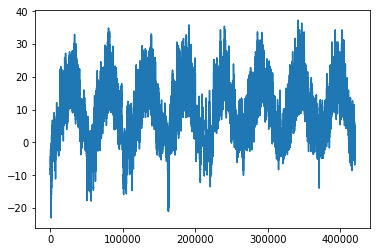

In [8]:
temp = float_data[:,1] #temperature
plt.plot(range(len(temp)), temp)

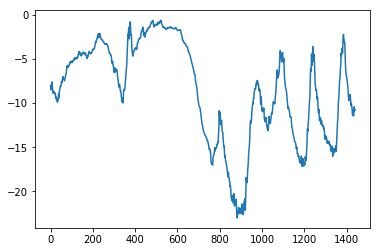

In [9]:
#first 10 days temperature data (updated by 10minutes)
plt.plot(range(1440), temp[:1440])

- 마지막 4일간 일별 주기성이 잘 드러난다
- 연간 데이터 주기성은 안정적이기 때문에 지난 몇 달간 데이터를 사용하여 다음 달의 평균 온도를 예측하는 문제는 쉬움
- 하루하루 데이터를 살펴보면 온도 변화는 불안정

# prepare datasets
- lookback = 1440 : 10일 전 데이터로 돌아간다
- steps = 6 : 1시간마다 데이터 포인트 하나를 샘필링
- delay = 144 : 24시간이 지난 데이터가 타깃이 된다


- train : first 20000

In [10]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

In [18]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6) :
    
    #data : standardized original data
    #lookback : input으로 사용하기 위해 거슬러 올라갈 타임스텝
    #delay : target으로 사용할 미래의 timestep
    #min_index, max_index : 추출할 타임스텝의 범위를 지정하기 위한 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용
    #step : 데이터를 샘플링할 타입스텝 간격. 1시간에 하나의 데이터 포인트를 추출하기 위해 6으로
    
    if max_index is None :
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1 :
        if shuffle :
            rows = np.random.randint(min_index + lookback, max_index, size= batch_size)
            
        else :
            if i + batch_size >= max_index :
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows) :
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets #generator, yield

In [19]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [20]:
train_gen = generator(float_data, lookback=lookback, delay = delay,
                     min_index=0, max_index=200000,
                     shuffle = True, step = step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay = delay,
                     min_index=200001, max_index=300000,
                     shuffle = True, step = step, batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay = delay,
                     min_index=300001, max_index=None,
                     shuffle = True, step = step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# 상식 수준의 모델
- 24시간 후 온도는 지금과 동일할 것이라고 예측!

In [21]:
def evaluate_naive_method() :
    batch_mases = []
    for step in range(val_steps) :
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1] #temperature column
        
        mae = np.mean(np.abs(preds - targets))
        batch_mases.append(mae)
        
    print(np.mean(batch_mases))
    
evaluate_naive_method()

0.289508423058381


In [23]:
celsius_mae = 0.29*std[1]
celsius_mae

2.5672247338393395

# basic Machine Learning
## 완전연결신경망

In [27]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.utils.training_utils import K

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))

with K.tf.device('/gpu:0') :
    model.compile(optimizer = RMSprop(), loss = 'mae')
    history  = model.fit_generator(train_gen,
                                  steps_per_epoch = 500, epochs = 20,
                                  validation_data = val_gen,
                                  validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 6s 13ms/step - loss: 1.0273 - val_loss: 0.4587
Epoch 2/20
500/500 [==============================] - 6s 13ms/step - loss: 0.3380 - val_loss: 0.3111
Epoch 3/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2777 - val_loss: 0.2949
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2592 - val_loss: 0.2954
Epoch 5/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2469 - val_loss: 0.3004
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2403 - val_loss: 0.3700
Epoch 7/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2354 - val_loss: 0.3136
Epoch 8/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2289 - val_loss: 0.3077
Epoch 9/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2272 - val_loss: 0.3396
Epoch 10/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2222 - val_lo

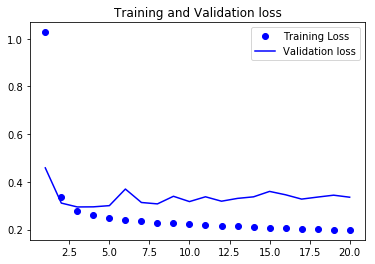

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

- 상식적인 모델로 적용한 0.29보다 크게 개선되지 않음
- 불안정함

# first RNN
- GRU

In [30]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [31]:
model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

with K.tf.device('/gpu:0') :
    model.compile(optimizer = RMSprop(), loss = 'mae')
    history = model.fit_generator(train_gen,
                                 steps_per_epoch = 500,
                                 epochs = 20,
                                 validation_data = val_gen,
                                 validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 83s 167ms/step - loss: 0.3094 - val_loss: 0.2694
Epoch 2/20
500/500 [==============================] - 83s 166ms/step - loss: 0.2836 - val_loss: 0.2686
Epoch 3/20
500/500 [==============================] - 83s 166ms/step - loss: 0.2763 - val_loss: 0.2661
Epoch 4/20
500/500 [==============================] - 83s 166ms/step - loss: 0.2699 - val_loss: 0.2690
Epoch 5/20
500/500 [==============================] - 83s 166ms/step - loss: 0.2671 - val_loss: 0.2691
Epoch 6/20
500/500 [==============================] - 83s 167ms/step - loss: 0.2608 - val_loss: 0.2711
Epoch 7/20
500/500 [==============================] - 83s 166ms/step - loss: 0.2549 - val_loss: 0.2719
Epoch 8/20
500/500 [==============================] - 83s 167ms/step - loss: 0.2503 - val_loss: 0.2819
Epoch 9/20
500/500 [==============================] - 83s 166ms/step - loss: 0.2459 - val_loss: 0.2789
Epoch 10/20
500/500 [==============================] - 83s 167ms/step - l

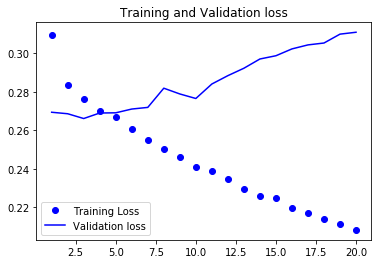

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,  + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [48]:
for i in range(1,len(loss)):
    if val_loss[i-1] >= val_loss[i] :
        print(i)
    else :
        break

1
2


In [49]:
print(val_loss[:3])
print('before overfitting best loss : ', np.min(val_loss[:3]))

[0.26941045760255794, 0.2686317098970066, 0.2661397266449947]
before overfitting best loss :  0.2661397266449947


improved

# Recurrent_dropout to avoid overfitting
- 순환 층 이전에 dropout을 적용하면 학습에 방해되는 것으로 알려져있음
- 랜덤하게 dropout mask를 바꾸는 것이 아니라 동일한 dropout mask(동일한 유닛의 드롭 패턴)를 몯느 타입스텝에 적용

In [50]:
model = Sequential()
model.add(layers.GRU(32, dropout = 0.2, #input_t dropout 비율
                        recurrent_dropout = 0.2, #state_t의 dropout
                        input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

with K.tf.device('/gpu:0') :
    model.compile(optimizer = RMSprop(), loss = 'mae')
    history = model.fit_generator(train_gen,
                                 steps_per_epoch = 500, epochs = 40,
                                 validation_data = val_gen, validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 96s 193ms/step - loss: 0.3322 - val_loss: 0.2785
Epoch 2/40
500/500 [==============================] - 95s 191ms/step - loss: 0.3174 - val_loss: 0.2736
Epoch 3/40
500/500 [==============================] - 95s 191ms/step - loss: 0.3091 - val_loss: 0.2692
Epoch 4/40
500/500 [==============================] - 95s 191ms/step - loss: 0.3055 - val_loss: 0.2712
Epoch 5/40
500/500 [==============================] - 95s 191ms/step - loss: 0.3021 - val_loss: 0.2680
Epoch 6/40
500/500 [==============================] - 96s 191ms/step - loss: 0.2977 - val_loss: 0.2658
Epoch 7/40
500/500 [==============================] - 96s 191ms/step - loss: 0.2981 - val_loss: 0.2718
Epoch 8/40
500/500 [==============================] - 95s 191ms/step - loss: 0.2940 - val_loss: 0.2646
Epoch 9/40
500/500 [==============================] - 96s 191ms/step - loss: 0.2939 - val_loss: 0.2638
Epoch 10/40
500/500 [==============================] - 96s 191ms/step - l

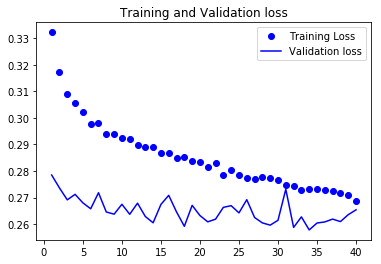

In [53]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,  len(loss) + 1)
plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

- val_loss가 보다 안정적으로 되었지만 이전보다 나아지지는 않음

# Stacking Recurrent Layer
- 병목이 있는 것 같다!
- 과대적합이 일어날 때까지 네트워크의  용량을 늘리는 것이 좋다 -> 층에 있는 유닛의 수를 늘리거나, 층을 더 많이 추가
- 순환 층을 차례로 쌓으려면, 중간층은 마짐가 타입스텝이 아니라 전체 시퀀스를 출력해야 한다(return_sequences = True)

In [54]:
from keras.utils.training_utils import multi_gpu_model

In [56]:
model = Sequential()
model.add(layers.GRU(32, 
                    dropout = 0.1, recurrent_dropout = 0.5,
                    return_sequences  = True,
                    input_shape = (None, float_data.shape[-1])))
model.add(layers.GRU(64,
                    activation = 'relu',
                     dropout = 0.1, recurrent_dropout = 0.5))
model.add(layers.Dense(1))
model = multi_gpu_model(model, gpus = 2)
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen,
                                 steps_per_epoch = 500, epochs = 40,
                                 validation_data = val_gen, validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 223s 446ms/step - loss: 0.3338 - val_loss: 0.2770
Epoch 2/40
431/500 [========================>.....] - ETA: 23s - loss: 0.3140

KeyboardInterrupt: 